# 文書分類

## データセットの読み込み

In [1]:
from glob import glob

In [2]:
import pandas as pd

In [3]:
directories = glob('text/*')
directories

['text/peachy',
 'text/topic-news',
 'text/sports-watch',
 'text/it-life-hack',
 'text/smax',
 'text/livedoor-homme',
 'text/movie-enter',
 'text/kaden-channel']

In [4]:
for(i, directory) in enumerate(directories): #enumerate()各要素に連番を振る
    print(i)
    print(directory)
    print('----------')

0
text/peachy
----------
1
text/topic-news
----------
2
text/sports-watch
----------
3
text/it-life-hack
----------
4
text/smax
----------
5
text/livedoor-homme
----------
6
text/movie-enter
----------
7
text/kaden-channel
----------


In [5]:
texts, labels = [], []
for (i, directory) in enumerate(directories):
    #各ディレクトリ内のtxtファイルのパスをすべて取得
    filepaths = glob('{}/*.txt'.format(directory))
    # テキストを読み込んで、内容をtextに格納、ラベルも併せて格納
    for filepath in filepaths:
        with open(filepath, encoding='utf-8') as f:#with open ：どうやって開くか
            text = ''.join(f.readlines()[2:])  # URL等の先頭２行を除いた各行の文章を連結（join）して格納
            texts.append(text)
            labels.append(i)

In [6]:
texts[0]

'実は転活中の女子は多い？！\u3000会社が求めるビジネススキルを身につけるには？\n\u3000総務省の労働力調査では働く女性の約10人に1人が転職を希望しているそうです。確かに、女性のキャリアって、考えれば考えるほど難しいですよね。仕事は続けたいけど、結婚や家庭にだって手を抜きたくない。だからこそ、長期のブランクにもなんら影響はないと自ら自信を持っていえるだけのスキルがあれば——、なんて思ったこと、ありませんか？\n\n\u3000今回はそんな“仕事もプライベートも充実させるためのスキルアップ“を目指す女性が集まるビジネススクールに、お邪魔してきました。このビジネススクールは、沢山の人気講師が集まっているんです。「面接の達人」著者である中谷彰宏先生を始めとして、脳科学の研究をしている黒川伊保子先生など有名な方ばかり。そんな講師陣が自身の経験を踏まえたノウハウを分かりやすく解説してくれます。\n\n○講師陣はスクールより有名？\n\u3000今回、参加したのは「大前研一のアタッカーズビジネススクール」で開講している「ビジネスモデル創造講座」。講師は、コンサルタント業界では有名な末吉孝生先生です。末吉先生は15年にわたり大手電機メーカー、住宅メーカー、アパレルメーカー等でマーケティング戦略の立案・実行や戦略プロジェクトチームを支援し、広告ベンチャー、ITベンチャー、コンサルティングファーム等の取締役を経て、現在はコンサルティング会社を経営しています。\n\n○遊園地で遊んで学ぶ!？\n\u3000講座の冒頭では、何を、何のために学ぶのかを明確にしていきます。今日は人気遊園地のマニュアルから、その人気の秘密を探っていきます。遊園地の接客マニュアルは非現実的な空間を作る上でとても大切で、そうして作り上げた空間が大きな利益を生むという理論を説明して頂きました。\n\n\u3000この不景気でも売上げを伸ばしている遊園地の接客マニュアルを分析して “ビジネスを設計する力（ビジネスモデリング）”を養います。実はこれ、企業が事業成長をさせるために必要なスキルなんだそうです。\n\u3000\n\u3000末吉先生は「遊園地における接客というサービスには形がありませんよね。でも顧客がいかに感動を生むか、という顧客心理を捕らえたマニュアルは非現実的な空間を作る上でとても大切で、そ

In [7]:
labels[0]

0

## 形態素解析 & 名詞の抽出

In [8]:
import MeCab
mecab = MeCab.Tagger('-Ochasen') # 分かち書き

In [9]:
def get_nouns(text):
    nouns = []
    res = mecab.parse(text)
    words = res.split('\n')[:-2] #EOFと\nを取り除き\nのあるところで改行されたリストを作る.
    for word in words:
        part = word.split('\t')
        if '名詞' in part[3]:
            nouns.append(part[0])
    return nouns

In [10]:
word_collect=[]
for text in texts:
    nouns = get_nouns(text)
    word_collect.append(nouns)

In [11]:
from gensim import corpora, matutils

In [12]:
dictionary = corpora.Dictionary(word_collect)

In [13]:
len(dictionary)

81051

In [14]:
#出現頻度の低い単語を削除
dictionary.filter_extremes(no_below=20)

In [15]:
len(dictionary)

6697

In [16]:
n_words = len(dictionary)

In [17]:
#Bowによるベクトル作成
x = []
for nouns in word_collect:
    bow_id = dictionary.doc2bow(nouns)
    bow = matutils.corpus2dense([bow_id], n_words).T[0] #bow_id全単語 入力変数は揃える
    x.append(bow)

## データの前処理,モデルの構築、モデルの学習と可視化

In [18]:
import numpy as np

In [19]:
x = np.array(x)
t = np.array(labels)

In [20]:
x.shape

(6505, 6697)

In [21]:
t.shape

(6505,)

 ## 得られたデータセットから、文書分類を行うNNモデルを作成する.

In [22]:
import os
import random

def reset_seed(seed=0):

    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(seed) #　random関数のシードを固定
    np.random.seed(seed) #numpyのシードを固定
    tf.random.set_seed(seed) #tensorflowのシードを固定

In [23]:
# Pythonの挙動を整えるライブラリのインポート
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow と tf. のインポート
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import models, layers

In [24]:
print(tf.__version__)

2.0.0


In [25]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_t, val_t = train_test_split(x, t, test_size=0.3, random_state = 0)

In [26]:
reset_seed(0)

model = models.Sequential()

model.add(layers.Dense(200, input_shape=(x.shape[1], ), activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

optimizer = keras.optimizers.SGD(lr=0.01)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [27]:
history = model.fit(train_x, train_t,
          batch_size=100,
          epochs=50,
          verbose=1,
          validation_data=(val_x, val_t))

Train on 4553 samples, validate on 1952 samples
Epoch 1/50
4553/4553 [==============================] - 1s 186us/sample - loss: 1.8651 - accuracy: 0.3892 - val_loss: 1.5367 - val_accuracy: 0.6281
Epoch 2/50
4553/4553 [==============================] - 0s 53us/sample - loss: 1.3482 - accuracy: 0.7358 - val_loss: 1.1917 - val_accuracy: 0.7935
Epoch 3/50
4553/4553 [==============================] - 0s 53us/sample - loss: 1.0539 - accuracy: 0.8430 - val_loss: 0.9659 - val_accuracy: 0.8545
Epoch 4/50
4553/4553 [==============================] - 0s 52us/sample - loss: 0.8541 - accuracy: 0.8880 - val_loss: 0.8074 - val_accuracy: 0.8755
Epoch 5/50
4553/4553 [==============================] - 0s 53us/sample - loss: 0.7120 - accuracy: 0.9049 - val_loss: 0.6938 - val_accuracy: 0.8878
Epoch 6/50
4553/4553 [==============================] - 0s 53us/sample - loss: 0.6069 - accuracy: 0.9192 - val_loss: 0.6108 - val_accuracy: 0.8940
Epoch 7/50
4553/4553 [==============================] - 0s 54us/sampl

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

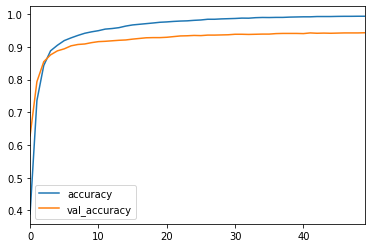

In [29]:
# 学習結果をPandasのDataFrame型で読み込みます。
results = pd.DataFrame(history.history)

# accuracy（精度）を表示
results[['accuracy', 'val_accuracy']].plot()